<a href="https://colab.research.google.com/github/Akhilesh-K-Yadav/NMA-22-DL-Saltenas-Project/blob/main/Saltenas2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import os, requests
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
import gzip
import plotnine as p9

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from IPython.display import display

from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

DEVICE = 'cuda'

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
mice = np.unique(pd.DataFrame(np.array(os.listdir('/content/drive/MyDrive/Mouse_Data/')))[0].apply(lambda x: x[0:15]))
print(mice)

vip_mouse_id = [467951, 467953, 467954, 489066, 492395]
sst_mouse_id = [470784, 476970, 477202, 480753, 485688, 489056, 498972]
slc_mouse_id = [461946, 462468, 462544, 464204, 464207]

['Slc_mouse461946' 'Slc_mouse462468' 'Slc_mouse462544' 'Slc_mouse464204'
 'Slc_mouse464207' 'Sst_mouse470784' 'Sst_mouse476970' 'Sst_mouse477202'
 'Sst_mouse480753' 'Sst_mouse485688' 'Sst_mouse489056' 'Sst_mouse498972'
 'Vip_mouse467951' 'Vip_mouse467953' 'Vip_mouse467954' 'Vip_mouse489066'
 'Vip_mouse492395' 'accuracy_data_N']


In [3]:
# Function to load in data from mounted drive on Colab
def load_gzip_arrays(fn, dir = '/content/drive/MyDrive/Mouse_Data/'):
    f = gzip.GzipFile(dir+fn+'_label.npy.gz', "r")
    label_data = np.load(f,allow_pickle=True)
    label_data = pd.DataFrame(label_data,columns=['image_name','is_change','omitted','session_number'])

    f = gzip.GzipFile(dir+fn+'_dffbc.npy.gz', "r")
    dff_bc = np.load(f)

    f = gzip.GzipFile(dir+fn+'_dffstim.npy.gz', "r")
    dff_stim = np.load(f)

    f = gzip.GzipFile(dir+fn+'_dffts.npy.gz', "r")
    dff_ts = np.load(f)

    return label_data, dff_bc, dff_stim, dff_ts

In [4]:
# Prepare input data
def prepare_data(dff_mat, label_data, trial_subset, cell_subset = None):
  if len(dff_mat.shape)==3:
    X = dff_mat[trial_subset,:,:].squeeze()
    if cell_subset==None:
      cell_subset = np.where(X.sum(axis=0).sum(axis=1)!=0)
    X = X[:,cell_subset,:].squeeze()
    X = np.nan_to_num(X)
    y = label_data.loc[trial_subset,'image_name']
    _, y = np.unique(y, return_inverse=True)

  elif len(dff_mat.shape)==2:
    X = dff_mat[trial_subset,:].squeeze()
    if cell_subset==None:
      cell_subset = np.where(X.sum(axis=0)!=0)
    X = X[:,cell_subset].squeeze()
    X = np.nan_to_num(X)
    y = label_data.loc[trial_subset,'image_name']
    _, y = np.unique(y, return_inverse=True)

  else:
    print('Error: dff_mat must be 2D or 3D')

  return X, y, cell_subset

In [5]:
class NetDropout(nn.Module):
  """
  Network Class - 2D with the following structure:
  nn.Linear(1, 300) + leaky_relu(self.dropout1(self.fc1(x))) # First fully connected layer with 0.4 dropout
  nn.Linear(300, 500) + leaky_relu(self.dropout2(self.fc2(x))) # Second fully connected layer with 0.2 dropout
  nn.Linear(500, 1) # Final fully connected layer
  """

  def __init__(self,input_feature_num):
    super(NetDropout, self).__init__()
    self.fc1 = nn.Linear(input_feature_num, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 8)
    #self.dropout1 = nn.Dropout(0.5)
    #self.dropout2 = nn.Dropout(0.2)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    #x = F.leaky_relu(self.dropout1(self.fc3(x)))
    #x = F.leaky_relu(self.dropout1(self.fc4(x)))
    output = self.fc3(x)
    return output

In [7]:
def fit_one_mouse(area, mouse_id, n_train_epochs, method='MLP'):
  fn = f'{area}_mouse{mouse_id}'
  print('--------------\n'+fn)
  label_data, dff_bc, dff_stim, dff_ts = load_gzip_arrays(fn)

  # Possible subsetting groups
  not_omitted = np.logical_not(label_data['omitted'])
  familiar = label_data['session_number']<=3
  novel = label_data['session_number']>3
  passive = np.logical_or(label_data['session_number']==2, label_data['session_number']==5)
  active = np.logical_not(passive)
  is_change = label_data['is_change']
  not_change = np.logical_not(is_change)

  # Choose train/test and out-of-distribution subsets
  subset = np.where(np.logical_and.reduce([not_change, not_omitted, familiar]))
  subset2 = np.where(np.logical_and.reduce([is_change, not_omitted, familiar]))

  # Prepare data
  X, y, cell_subset = prepare_data(dff_stim, label_data, subset[0])
  X_out, y_out, _ = prepare_data(dff_stim, label_data, subset2[0], cell_subset)

  # Create train/test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, stratify=y)

  if method=='MLP':
    X_train = torch.Tensor(X_train).to(DEVICE)
    X_test = torch.Tensor(X_test).to(DEVICE)
    y_train = torch.Tensor(y_train).to(torch.int64).to(DEVICE)
    y_test = torch.Tensor(y_test).to(torch.int64).to(DEVICE)
    X_out = torch.Tensor(X_out).to(DEVICE)
    y_out = torch.Tensor(y_out).to(torch.int64).to(DEVICE)

    # Initialize network
    net = NetDropout(X_train.shape[1]).to(DEVICE)
    optimizer = optim.Adam(net.parameters(), weight_decay=1e-4, lr=1e-2)
    criterion = nn.CrossEntropyLoss()

    training_losses = np.empty(n_train_epochs)
    validation_losses = np.empty(n_train_epochs)
    out_losses = np.empty(n_train_epochs)
    training_accs = np.empty(n_train_epochs)
    validation_accs = np.empty(n_train_epochs)
    out_accs = np.empty(n_train_epochs)

    net.train()
    for i in tqdm(range(n_train_epochs)):
      optimizer.zero_grad()

      yhat_val = net(X_test).to(DEVICE)
      loss_val = criterion(yhat_val, y_test)

      yhat_out = net(X_out).to(DEVICE)
      loss_out = criterion(yhat_out, y_out)
      
      yhat_train = net(X_train).to(DEVICE)
      loss = criterion(yhat_train, y_train)
      loss.backward()
      optimizer.step()

      training_losses[i] = loss.item()
      validation_losses[i] = loss_val.item()
      out_losses[i] = loss_out.item()

      _, yhat_train_max = torch.max(yhat_train, 1)
      training_accs[i] = (yhat_train_max == y_train).float().sum()/len(yhat_train_max)

      _, yhat_val_max = torch.max(yhat_val, 1)
      validation_accs[i] = (yhat_val_max == y_test).float().sum()/len(yhat_val_max)

      _, yhat_out_max = torch.max(yhat_out, 1)
      out_accs[i] = (yhat_out_max == y_out).float().sum()/len(yhat_out_max)

    # Evaluate
    net.eval()

    # plt.figure()
    # plt.title(fn)
    # plt.ylabel('Training Loss')
    # plt.xlabel('Epoch')
    # plt.plot(training_losses,label='train')
    # plt.plot(validation_losses,label='validate')
    # plt.plot(out_losses,label='is_change')
    # plt.legend()

    # plt.figure()
    # plt.title(fn)
    # plt.ylabel('Training Accuracy')
    # plt.xlabel('Epoch')
    # plt.plot(training_accs,label='train')
    # plt.plot(validation_accs,label='validate')
    # plt.plot(out_accs,label='is_change')
    # plt.legend()

    train_acc = np.median(training_accs[:-7])
    test_acc = np.median(validation_accs[:-7])
    out_acc = np.median(out_accs[:-7])

  elif method=='SVM':
    model = SVC(probability=True)
    model.fit(X_train, y_train)
    yhat_train = model.predict(X_train)
    yhat_val = model.predict(X_test)
    yhat_out = model.predict(X_out)

    train_acc = accuracy_score(y_train, yhat_train)
    test_acc = accuracy_score(y_test, yhat_val)
    out_acc = accuracy_score(y_out, yhat_out)

    # cm = confusion_matrix(y_test, yhat_test)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # disp.plot()
    # plt.show()

  print(f'Training score: {np.round(train_acc,2)}')
  print(f'Test score: {np.round(test_acc,2)}')
  print(f'Out score: {np.round(out_acc,2)}')

  acc_data = pd.DataFrame({'accuracy':[train_acc,test_acc,out_acc],'data':['train','test','out'],'mouse':mouse_id,'area':area,'n_cells':len(cell_subset)})
  return acc_data

accuracy_data = []
for area, mouse_ids in zip(['Slc','Sst','Vip'],[slc_mouse_id,sst_mouse_id,vip_mouse_id]):
  for mouse_id in mouse_ids:
    n_train_epochs = 500
    mouse_acc_data = fit_one_mouse(area, mouse_id, n_train_epochs) #, method='SVM')
    accuracy_data.append(mouse_acc_data)

accuracy_data = pd.concat(accuracy_data)

--------------
Slc_mouse461946


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.94
Test score: 0.53
Out score: 0.63
--------------
Slc_mouse462468


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 1.0
Test score: 0.89
Out score: 0.31
--------------
Slc_mouse462544


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 1.0
Test score: 0.81
Out score: 0.87
--------------
Slc_mouse464204


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 1.0
Test score: 0.92
Out score: 0.93
--------------
Slc_mouse464207


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.88
Test score: 0.63
Out score: 0.74
--------------
Sst_mouse470784


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.7
Test score: 0.65
Out score: 0.49
--------------
Sst_mouse476970


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.65
Test score: 0.62
Out score: 0.58
--------------
Sst_mouse477202


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.45
Test score: 0.42
Out score: 0.39
--------------
Sst_mouse480753


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.35
Test score: 0.34
Out score: 0.24
--------------
Sst_mouse485688


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.54
Test score: 0.47
Out score: 0.39
--------------
Sst_mouse489056


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.38
Test score: 0.36
Out score: 0.3
--------------
Sst_mouse498972


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.46
Test score: 0.46
Out score: 0.41
--------------
Vip_mouse467951


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.23
Test score: 0.17
Out score: 0.14
--------------
Vip_mouse467953


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.43
Test score: 0.32
Out score: 0.17
--------------
Vip_mouse467954


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.24
Test score: 0.18
Out score: 0.13
--------------
Vip_mouse489066


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.31
Test score: 0.24
Out score: 0.13
--------------
Vip_mouse492395


  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 0.36
Test score: 0.26
Out score: 0.17


In [59]:
accuracy_data.to_pickle('/content/drive/MyDrive/Mouse_Data/accuracy_data_N17_MLPdffstim')

In [8]:
def accuracy_plot(accuracy_data):
  accuracy_data = accuracy_data.astype({'mouse':'category','data':'category','area':'category'})
  accuracy_data['data'] = pd.Categorical(accuracy_data['data'],categories=['train','test','out'])

  print(p9.ggplot(accuracy_data, p9.aes('area','accuracy'))
    + p9.scale_x_discrete()
    + p9.facet_grid('. ~ data')
    + p9.stat_summary()
    + p9.geom_point(p9.aes(color='mouse'),position=p9.positions.position_dodge(width=0.33), alpha=0.7)
    + p9.theme_matplotlib()
    + p9.geom_hline(yintercept=0.125,color='red',linetype='dashed')
    + p9.theme(figure_size=(10,4))
    )

/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor

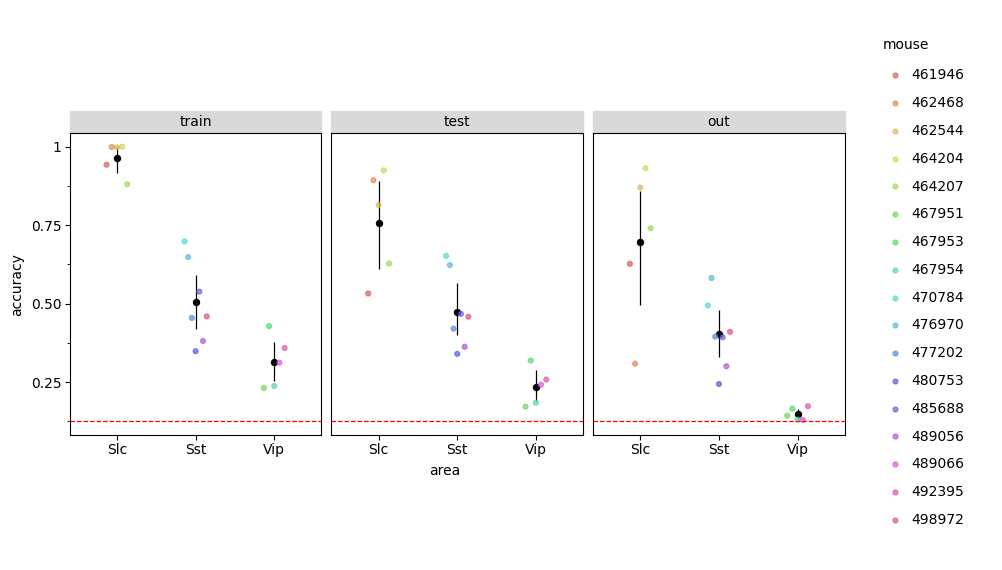

<ggplot: (8769251648753)>


In [9]:
accuracy_plot(accuracy_data)

In [10]:
# SVM results (not saved, hand-copied from console output, DO NOT MODIFY!)
train_acc = [0.74,0.93,0.93,0.97,0.83,0.67,0.66,0.51,0.38,0.56,0.42,0.52,0.3,0.44,0.26,0.28,0.38]
test_acc = [0.51,0.73,0.81,0.94,0.62,0.64,0.63,0.45,0.35,0.53,0.35,0.46,0.14,0.3,0.19,0.19,0.26]
out_acc = [0.6,0.88,0.87,0.97,0.76,0.6,0.6,0.45,0.27,0.44,0.33,0.51,0.13,0.18,0.12,0.15,0.18]
mouse_id = [461946,462468,462544,464204,464207,470784,476970,477202,480753,485688,489056,498972,467951,467953,467954,489066,492395]
area=['Slc','Slc','Slc','Slc','Slc','Sst','Sst','Sst','Sst','Sst','Sst','Sst','Vip','Vip','Vip','Vip','Vip']
data=['train','test','out']
accuracy_data = pd.DataFrame({'accuracy':np.concatenate([train_acc,test_acc,out_acc]),'data':np.repeat(data,17),'mouse':np.tile(mouse_id,3),'area':np.tile(area,3),'n_cells':1})
#accuracy_data.to_pickle('/content/drive/MyDrive/Mouse_Data/accuracy_data_N17_SVMdffbc.pkl')


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor

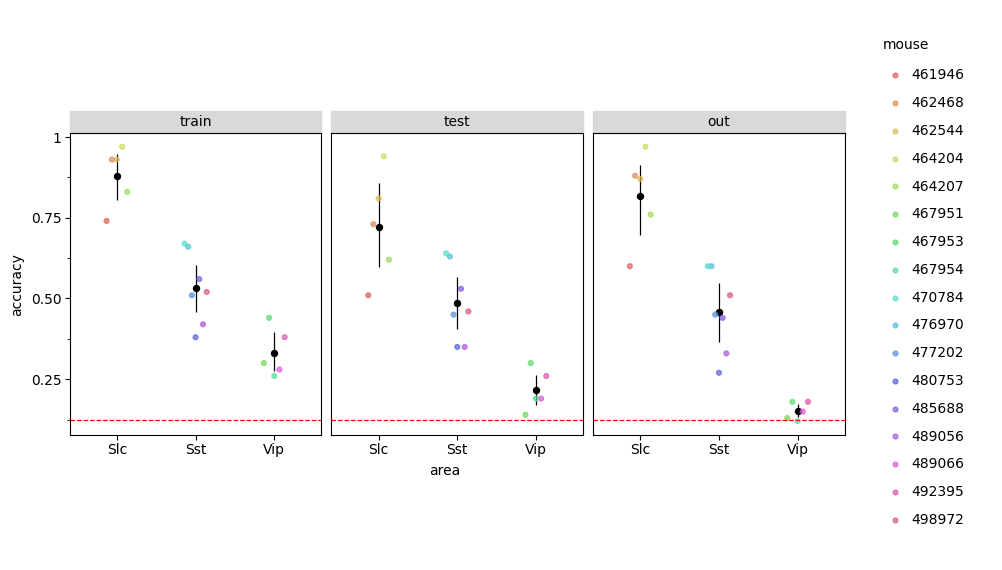

<ggplot: (8764314486597)>


In [20]:
accuracy_plot(accuracy_data)

/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor

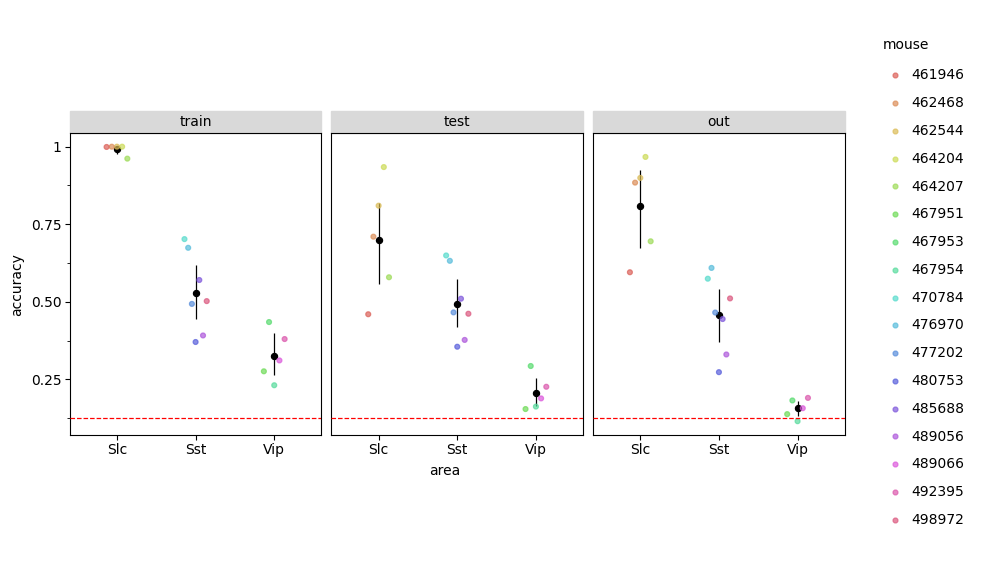

<ggplot: (8764311372593)>


In [21]:
accuracy_plot(pd.read_pickle('/content/drive/MyDrive/Mouse_Data/accuracy_data_N17_MLPdffbc'))

/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  margin_vars = [list(data.columns & self.rows),
/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  list(data.columns & self.cols)]
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/themes/theme.py:250: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor

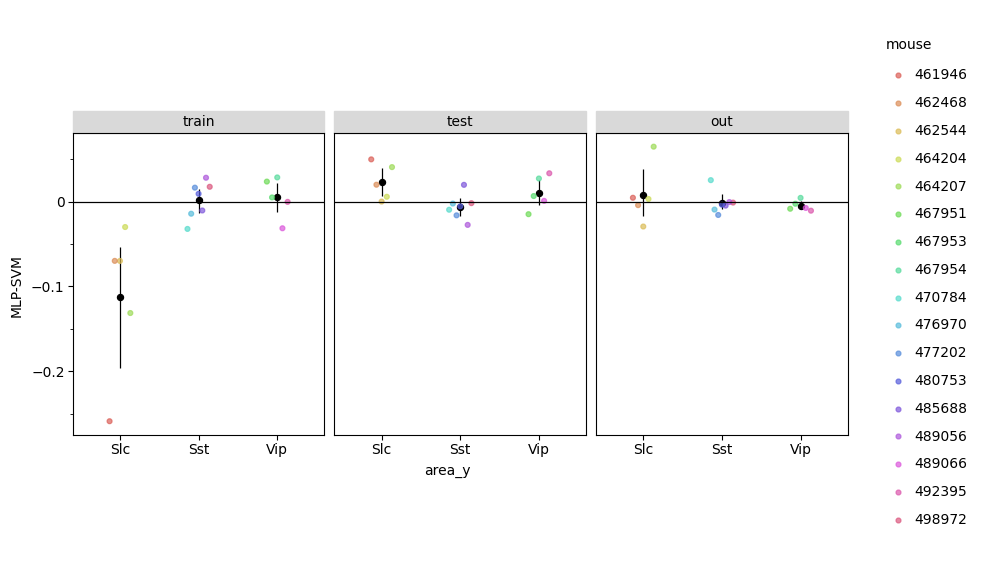

<ggplot: (8764310920401)>

In [35]:
lol = pd.read_pickle('/content/drive/MyDrive/Mouse_Data/accuracy_data_N17_MLPdffbc')

lol = lol.merge(accuracy_data,
          how='left',
          on=['mouse','data'],
          )

lol['MLP-SVM'] = lol['accuracy_y']-lol['accuracy_x']
lol = lol.astype({'mouse':'category','data':'category','area_y':'category'})
lol['data'] = pd.Categorical(lol['data'],categories=['train','test','out'])
(p9.ggplot(lol, p9.aes('area_y','MLP-SVM'))
    + p9.scale_x_discrete()
    + p9.facet_grid('. ~ data')
    + p9.stat_summary()
    + p9.geom_point(p9.aes(color='mouse'),position=p9.positions.position_dodge(width=0.33), alpha=0.7)
    + p9.theme_matplotlib()
    + p9.geom_hline(yintercept=0,color='black')
    + p9.theme(figure_size=(10,4))
)

In [ ]:
score_test = {}
score_train = {}
score_out = {}

# Select a mouse
area = 'Slc'
mouse_id = slc_mouse_id[1]

fn = f'{area}_mouse{mouse_id}'
label_data, dff_bc, dff_stim, dff_ts = load_gzip_arrays(fn)

In [45]:
# Possible subsetting groups
not_omitted = np.logical_not(label_data['omitted'])
familiar = label_data['session_number']<=3
novel = label_data['session_number']>3
passive = np.logical_or(label_data['session_number']==2, label_data['session_number']==5)
active = np.logical_not(passive)
is_change = label_data['is_change']
not_change = np.logical_not(is_change)

# Choose a subset
subset = np.where(np.logical_and.reduce([not_change, not_omitted, familiar]))
subset2 = np.where(np.logical_and.reduce([is_change, not_omitted, familiar]))

len(subset[0])

12966

In [95]:
# Prepare input data (mean firing rates: dff_bc or dff_stim)
X, y, cell_subset = prepare_data(dff_bc, subset)
X2, y2, = prepare_data(dff_bc, subset2, cell_subset)

In [89]:
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, stratify=y)

# Initialize network
net = NetDropout(X_train.shape[1]).to(DEVICE)
optimizer = optim.Adam(net.parameters(), weight_decay=1e-4, lr=1e-2)
criterion = nn.CrossEntropyLoss()
X_train = torch.Tensor(X_train).to(DEVICE)
X_test = torch.Tensor(X_test).to(DEVICE)
y_train = torch.Tensor(y_train).to(torch.int64).to(DEVICE)
y_test = torch.Tensor(y_test).to(torch.int64).to(DEVICE)

In [90]:
# Train
N_epochs = 500
training_losses = np.empty(N_epochs)
validation_losses = np.empty(N_epochs)
out_losses = np.empty(N_epochs)
training_accs = np.empty(N_epochs)
validation_accs = np.empty(N_epochs)
out_accs = np.empty(N_epochs)

net.train()
for i in tqdm(range(N_epochs)):
  optimizer.zero_grad()
  yhat_val = net(X_test).to(DEVICE)
  loss_val = criterion(yhat_val, y_test)
  yhat_out = net(X2).to(DEVICE)
  loss_out = criterion(yhat_out, y2)
  yhat_train = net(X_train).to(DEVICE)
  loss = criterion(yhat_train, y_train)
  loss.backward()
  optimizer.step()
  training_losses[i] = loss.item()
  validation_losses[i] = loss_val.item()
  out_losses[i] = loss_out.item()

  _, yhat_train_max = torch.max(yhat_train, 1)
  training_accs[i] = (yhat_train_max == y_train).float().sum()/len(yhat_train_max)

  _, yhat_val_max = torch.max(yhat_val, 1)
  validation_accs[i] = (yhat_val_max == y_test).float().sum()/len(yhat_val_max)

  _, yhat_out_max = torch.max(yhat_out, 1)
  out_accs[i] = (yhat_out_max == y2).float().sum()/len(yhat_out_max)

  0%|          | 0/500 [00:00<?, ?it/s]

Training score: 1.0
Test score: 0.9321511179645335
Out score: 0.30963302752293576


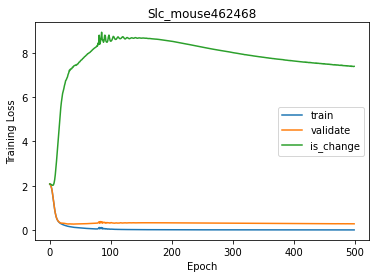

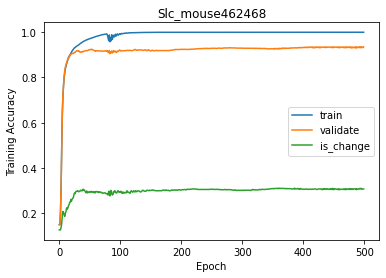

In [91]:
# Evaluate
net.eval()

plt.figure()
plt.title(fn)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
# lossdf = pd.DataFrame({'training':training_losses,
#               'validation':validation_losses,
#               'is_change':out_losses})
plt.plot(training_losses,label='train')
plt.plot(validation_losses,label='validate')
plt.plot(out_losses,label='is_change')
plt.legend()

plt.figure()
plt.title(fn)
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
# lossdf = pd.DataFrame({'training':training_losses,
#               'validation':validation_losses,
#               'is_change':out_losses})
plt.plot(training_accs,label='train')
plt.plot(validation_accs,label='validate')
plt.plot(out_accs,label='is_change')
plt.legend()

yhat_train = net(X_train).to('cpu')
_, yhat_train = torch.max(yhat_train, 1)
score_train[mouse_id] = accuracy_score(y_train.to('cpu'), yhat_train)
print(f'Training score: {score_train[mouse_id]}')

yhat_test = net(X_test).to('cpu')
_, yhat_test = torch.max(yhat_test, 1)
score_test[mouse_id] = accuracy_score(y_test.to('cpu'), yhat_test)
print(f'Test score: {score_test[mouse_id]}')

yhat_out = net(X2).to('cpu')
_, yhat_out = torch.max(yhat_out, 1)
score_out[mouse_id] = accuracy_score(y2.to('cpu'), yhat_out)
print(f'Out score: {score_out[mouse_id]}')

In [56]:
class ConvNetDropout(nn.Module):
  """
  """

  def __init__(self,input_feature_num):
    super(ConvNetDropout, self).__init__()
    filters_num = 1
    self.conv = nn.Conv1d(input_feature_num,filters_num*input_feature_num,kernel_size=5,padding=2,stride=1)
    #self.pool = nn.AdaptiveAvgPool1d(1)
    self.fc1 = nn.Linear(filters_num*input_feature_num, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 8)

  def forward(self, x):
    x0 = self.conv(x)
    #x1 = torch.squeeze(self.pool(x0))
    x1 = torch.amax(x0,2)
    x2 = F.leaky_relu(self.fc1(x1))
    x3 = F.leaky_relu(self.fc2(x2))
    output = self.fc3(x3)
    return output

In [57]:
# Prepare input data (time series firing rates)
X, y, cell_subset = prepare_data(dff_ts, subset)
X2, y2, _ = prepare_data(dff_ts, subset2, cell_subset)

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, stratify=y)

X_train = torch.Tensor(X_train).to(DEVICE)
X_test = torch.Tensor(X_test).to(DEVICE)
y_train = torch.Tensor(y_train).to(torch.int64).to(DEVICE)
y_test = torch.Tensor(y_test).to(torch.int64).to(DEVICE)

# Initialize
net = ConvNetDropout(X_train.shape[1]).to(DEVICE)
optimizer = optim.Adam(net.parameters(), weight_decay=1e-4, lr=1e-2)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Train
N_epochs = 500
training_losses = np.empty(N_epochs)
validation_losses = np.empty(N_epochs)
out_losses = np.empty(N_epochs)
training_accs = np.empty(N_epochs)
validation_accs = np.empty(N_epochs)
out_accs = np.empty(N_epochs)
net.train()
for i in tqdm(range(N_epochs)):
  optimizer.zero_grad()
  yhat_val = net(X_test)
  yhat_val = yhat_val.to(DEVICE)
  loss_val = criterion(yhat_val, y_test)
  yhat_out = net(X2).to(DEVICE)
  loss_out = criterion(yhat_out, y2)
  yhat_train = net(X_train).to(DEVICE)
  loss = criterion(yhat_train, y_train)
  loss.backward()
  optimizer.step()
  training_losses[i] = loss.item()
  validation_losses[i] = loss_val.item()
  out_losses[i] = loss_out.item()

  _, yhat_train_max = torch.max(yhat_train, 1)
  training_accs[i] = (yhat_train_max == y_train).float().sum()/len(yhat_train_max)

  _, yhat_val_max = torch.max(yhat_val, 1)
  validation_accs[i] = (yhat_val_max == y_test).float().sum()/len(yhat_val_max)

  _, yhat_out_max = torch.max(yhat_out, 1)
  out_accs[i] = (yhat_out_max == y2).float().sum()/len(yhat_out_max)

  # _, yhat_train = torch.max(yhat_train, 1)
  # score_train[mouse_id] = accuracy_score(y_train.to('cpu'), yhat_train)

Training score: 0.5272573124205172
Test score: 0.17543859649122806
Out score: 0.14112903225806453


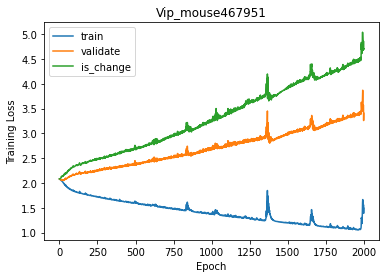

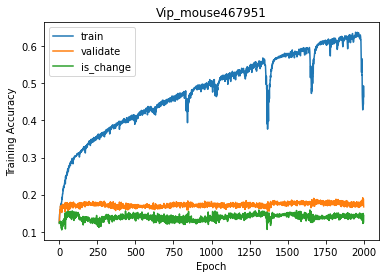

In [37]:
# Evaluate
net.eval()

plt.figure()
plt.title(fn)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.plot(training_losses,label='train')
plt.plot(validation_losses,label='validate')
plt.plot(out_losses,label='is_change')
plt.legend()

plt.figure()
plt.title(fn)
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.plot(training_accs,label='train')
plt.plot(validation_accs,label='validate')
plt.plot(out_accs,label='is_change')
plt.legend()

yhat_train = net(X_train).to('cpu')
_, yhat_train = torch.max(yhat_train, 1)
score_train[mouse_id] = accuracy_score(y_train.to('cpu'), yhat_train)
print(f'Training score: {score_train[mouse_id]}')

yhat_test = net(X_test).to('cpu')
_, yhat_test = torch.max(yhat_test, 1)
score_test[mouse_id] = accuracy_score(y_test.to('cpu'), yhat_test)
print(f'Test score: {score_test[mouse_id]}')

yhat_out = net(X2).to('cpu')
_, yhat_out = torch.max(yhat_out, 1)
score_out[mouse_id] = accuracy_score(y2.to('cpu'), yhat_out)
print(f'Out score: {score_out[mouse_id]}')